# Sentiment Analysis of Apple and Google Product Tweets

## Overview

This project focuses on building a Natural Language Processing (NLP) model to classify the sentiment of Twitter posts related to Apple and Google products. Using a labeled dataset of tweets, the model predicts whether a tweet expresses positive, negative, or neutral sentiment. The project demonstrates an end-to-end NLP workflow, from data understanding and preparation to feature engineering and modeling, with the goal of producing a practical proof of concept for sentiment analysis.

### Problem Statement

Technology companies receive thousands of tweets daily from users expressing opinions about their products. Manually analyzing this feedback is inefficient, subjective, and not scalable. As a result, organizations struggle to quickly understand public sentiment and respond to customer concerns in a timely manner. This project addresses the challenge of automatically classifying tweet sentiment to help stakeholders efficiently analyze large volumes of social media data.

### Business Understanding

This project addresses the challenge of monitoring customer sentiment at scale on social media platforms such as Twitter. It supports stakeholders including marketing teams, product managers, and social media analysts at Apple and Google by automatically classifying tweets as positive, negative, or neutral. By interpreting consumer sentiment, businesses can gain actionable insights, address issues promptly, and refine marketing strategies. 

### Objectives

The objectives of this project are to:
- Build an accurate sentiment analysis model

- Classify tweets as positive, negative, or neutral

- Extract meaningful insights from social media data

- Support improved brand perception and customer satisfaction

### Data Understanding

The dataset used in this project comes from CrowdFlower (via data.world) and contains over 9,000 tweets related to Apple and Google products, each labeled by human annotators as positive, negative, or neutral, making it suitable for supervised learning. The tweets are short, informal, and typical of social media, with the sentiment label as the target variable. This data directly represents real customer opinions, making it highly relevant for analyzing public sentiment toward technology brands. However, the dataset has limitations: tweets may lack context, sentiment labels can be subjective, and there may be class imbalances across sentiment categories.

### Data Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from string import punctuation

#scipy
from scipy.sparse import csr_matrix

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
#xgboost
import xgboost as xgb

#nlkt
from nltk import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

import joblib

In [2]:
# Load dataset
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# Checking data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
#checking the shape of the dataframe
df.shape


(9093, 3)

In [5]:
# Renaming the column names
df.columns = ['tweet_text', 'brand_item', 'emotion']
df.head()

,tweet_text,brand_item,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
#checking for null values
null_percentages = df.isna().mean() * 100
print(null_percentages)

tweet_text     0.010997
brand_item    63.807324
emotion        0.000000
dtype: float64


In [7]:
# checking the tweet_text column null values
df[df['tweet_text'].isnull()]

,tweet_text,brand_item,emotion
6,NaN,NaN,No emotion toward brand or product


In [8]:
# dropping the null values from tweet_text column
df.dropna(subset = ['tweet_text'], inplace = True)
# checking for the null values
null_percentages = (df.isnull().mean() * 100)
print(null_percentages)

tweet_text     0.000000
brand_item    63.803344
emotion        0.000000
dtype: float64


In [9]:
# Checking for duplicates
df.duplicated().sum()

22

In [10]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [11]:
#remaping categories 
emotion_map = {'No emotion toward brand or product': 'Neutral emotion', 
              'Positive emotion': 'Positive emotion',
              'Negative emotion': 'Negative emotion',
              'I can\'t tell': 'Cant tell'}

df.emotion = df.emotion.map(emotion_map)
df.emotion.value_counts()

Neutral emotion     5375
Positive emotion    2970
Negative emotion     569
Cant tell            156
Name: emotion, dtype: int64

The presence of "I can't tell" entries introduces ambiguity into the dataset, as they do not provide clear sentiment information. This ambiguity can impact the accuracy of sentiment analysis models, as it is uncertain whether these entries represent positive, negative, or neutral sentiments. Considering the relatively low proportion of such data, it was preferred to remove these entries to maintain the clarity and reliability of the dataset for more accurate sentiment analysis.

In [12]:
# Drop rows where emotion is 'I can't tell'
df.drop(index=df[df['emotion'] == 'Cant tell'].index, inplace= True)
df.reset_index(drop=True, inplace=True)
df

,tweet_text,brand_item,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8909,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8910,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral emotion
8911,"Google's Zeiger, a physician never reported po...",NaN,Neutral emotion
8912,Some Verizon iPhone customers complained their...,NaN,Neutral emotion


In [13]:
# drop index 8913 with wierd characters since they cannot be decoded
df.drop(index=8913, inplace= True)
# Reset index and drop the old index
df.reset_index(drop=True, inplace=True)
df

,tweet_text,brand_item,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8908,"@mention Yup, but I don't have a third app yet...",NaN,Neutral emotion
8909,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8910,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral emotion
8911,"Google's Zeiger, a physician never reported po...",NaN,Neutral emotion


In [14]:
def fill_missing_brand_item(df):
    # 1. Create a mask to only target rows where brand_item is missing
    missing_mask = df['brand_item'].isna()

    # 2. Define your clues
    # Logic for Apple (includes iPad and iPhone)
    apple_clues = 'ipad|iphone|apple|itunes|pop store'

    # Logic for Google (includes Android)
    google_clues = 'google|android|circles'

    # 3. Apply changes using .loc for safety and speed
    # We use case=False to handle 'IPHONE', 'iphone', and 'iPhone' all at once
    
    # Fill Apple
    df.loc[missing_mask & df['tweet_text'].str.contains(apple_clues, case=False, na=False), 'brand_item'] = 'Apple'

    # Fill Google
    df.loc[missing_mask & df['tweet_text'].str.contains(google_clues, case=False, na=False), 'brand_item'] = 'Google'

    # 4. Fill any remaining blanks as 'Unknown'
    df['brand_item'] = df['brand_item'].fillna('Unknown')

    return df

# Execute the function
df = fill_missing_brand_item(df)

# Check the new results
print("Missing values after imputation:", df['brand_item'].isna().sum())
print("\nNew Brand Item Counts:")
print(df['brand_item'].value_counts())

Missing values after imputation: 0

New Brand Item Counts:
Apple                              3562
Google                             2477
iPad                                941
Unknown                             685
iPad or iPhone App                  469
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Other Apple product or service       35
Name: brand_item, dtype: int64


In [15]:
# Drop rows where brand_item is 'Unknown'
df = df[df['brand_item'] != 'Unknown']
df.reset_index(drop=True, inplace=True)

In [16]:
def brand_company_vectorized(df):
    # Define your lists
    apple_list = ['iPad', 'Apple', 'iPhone', 'iPad or iPhone App', 'ipad', 'apple', 'iphone', 'Other Apple product or service']
    google_list = ['Google', 'google', 'Other Google product or service', 'Android', 'Android App', 'android']
    
    # Make a copy 
    df = df.copy()
    
    # Use .isin() to map values in bulk
    df.loc[df['brand_item'].isin(apple_list), 'brand_company'] = 'Apple'
    df.loc[df['brand_item'].isin(google_list), 'brand_company'] = 'Google'
    
    return df

# Apply 
df = brand_company_vectorized(df)

In [17]:
null_percentages = df.isna().mean() * 100
print(null_percentages)
df

tweet_text       0.0
brand_item       0.0
emotion          0.0
brand_company    0.0
dtype: float64


,tweet_text,brand_item,emotion,brand_company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
8223,"@mention Yup, but I don't have a third app yet...",Google,Neutral emotion,Google
8224,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
8225,"Wave, buzz... RT @mention We interrupt your re...",Google,Neutral emotion,Google
8226,"Google's Zeiger, a physician never reported po...",Google,Neutral emotion,Google


In [18]:
# Function to remove tweet handles(words that start with @), HTML tags and URLs in tweets
def remove_html_urls_mentions(input_text):
    # Remove HTML tags
    pattern_html = re.compile('<.*?>')
    text = pattern_html.sub(r'', input_text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove Twitter usernames (mentions)
    text = re.sub(r'@\w+\s*', '', text)
    
    # Remove 'RT' (Retweet terms)
    text = re.sub(r'\bRT\b', '', text)
    
    # Remove words within curly braces {} and the braces themselves
    text = re.sub(r'\{[^}]*\}', '', text)
    
    # Remove words within square brackets [] and the brackets themselves
    text = re.sub(r'\[[^]]*\]', '', text)
    
    # Remove words within parentheses () and the parentheses themselves
    text = re.sub(r'\([^)]*\)', '', text)
    
    # Define the pattern to match any non-alphanumeric characters
    pattern = r'[^a-zA-Z0-9\s]'  # This pattern matches any character that is not a letter, digit, or whitespace

    # Replace all non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text


In [ ]:
df['cleaned_tweet'] = df['tweet_text'].apply(
    lambda text: remove_html_urls_mentions(text)
)
df = df[['tweet_text', 'cleaned_tweet', 'brand_item', 'emotion', 'brand_company']].copy()
df

### Explanatory Data Analysis

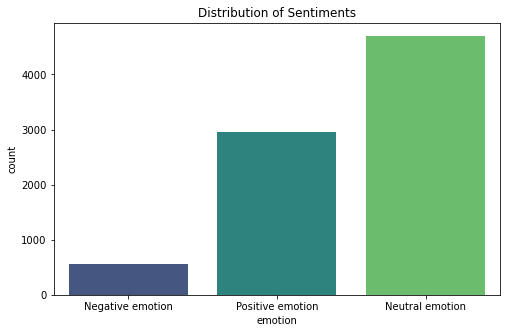

Neutral emotion     0.571220
Positive emotion    0.359747
Negative emotion    0.069033
Name: emotion, dtype: float64


In [21]:
# Distribution of Sentiments visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='emotion', data=df, palette='viridis')
plt.title('Distribution of Sentiments')
plt.show()

# Show percentages to be precise
print(df['emotion'].value_counts(normalize=True))

Negative is significantly less than neutral and positive which shows that there is class imbalance in the emotions.


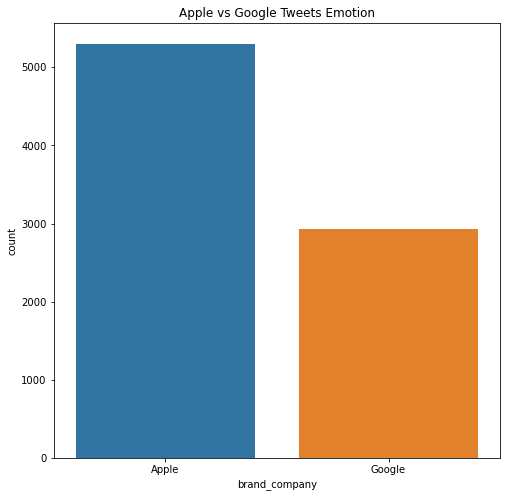

In [22]:
# counterplot of company tweets distribution
plt.figure(figsize=(8,8))
sns.countplot(x="brand_company", data=df)
plt.title('Apple vs Google Tweets Emotion')
plt.show()


Apple has significantly more tweets compared to google

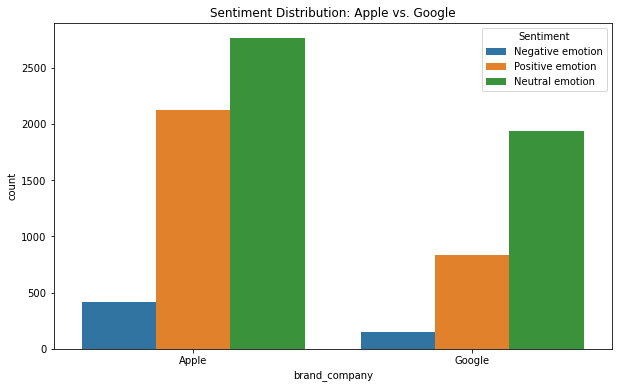

In [23]:
# Visualization of brand company
plt.figure(figsize=(10, 6))
sns.countplot(x='brand_company', hue='emotion', data=df)
plt.title('Sentiment Distribution: Apple vs. Google')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

positive sentiment significantly outweighed negative sentiment, suggesting a generally good brand perception for both apple and google at the time.

Apple generates more reaction than Google in this specific dataset. However, the ratio of positive-to-negative sentiment remains relatively stable across both brands.

## Modeling

####  NAIVE BAYES

In [25]:
#defining x and y
X = df['cleaned_tweet'].fillna('')
y = df['emotion']
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y )


To solve the class imbalance issue, the complement Naive bayes model, TF-idf and class priors were used.

With class priors, minority classes get a fairer chance.
Rare classes are over-assumed and
common classes are under assumed

In [26]:
from collections import Counter
counts = Counter(y_train)
#counts unique labels in y train
total = sum(counts.values())
#total sample in y train

class_priors = [counts[c] / total for c in sorted(counts)]
#calculates prior probability


In [27]:
from sklearn.naive_bayes import ComplementNB
nb_model = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=1)),
    ('nb', ComplementNB(class_prior=class_priors))
])
#fits the naive bayes model
nb_model.fit(X_train, y_train)
#evaluates the model
print(classification_report(y_test, nb_model.predict(X_test)))


                  precision    recall  f1-score   support

Negative emotion       0.53      0.25      0.34       114
 Neutral emotion       0.67      0.81      0.74       940
Positive emotion       0.62      0.48      0.54       592

        accuracy                           0.65      1646
       macro avg       0.61      0.52      0.54      1646
    weighted avg       0.64      0.65      0.64      1646



INTERPRETATION.

Negative emotion - precision, (0.53) The model correctly predicts 53% of the tweets negative, (0.25) the model catches about 25% of all negative tweets.

Neutral emotion - precision, (0.67) 67% of tweets predicted as neutral were actually neutral.
recall (0.81)- The model catches about 81% of neutral tweets

Positive emotion - precision, (0.62) and recall(0.48) 62% of tweets predicted as positive were actually npositive and the model catches 48% of all positive tweets

The Complement Naive bayes Model is 65% accurate

### SVM MODEL

In [28]:
# pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', LinearSVC(class_weight='balanced', random_state=42))
])

# Hyperparameter grid 
param_grid = {
    # TF-IDF parameters
    'tfidf__ngram_range': [(1,1), (1,2)],  # unigrams or bigrams
    'tfidf__max_features': [3000, 5000, 8000],  # limit of tf-idf features

    # LinearSVC parameters
    'svm__C': [0.1, 1, 10],  # regularization strength
    'svm__loss': ['hinge', 'squared_hinge']  # loss function options
}

# GridSearchCV setup
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Gets the best model
best_svm_model = grid_search.best_estimator_

# Show the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Make predictions on test set
y_pred = best_svm_model.predict(X_test)

# Evaluate
print("\nTuned SVM Results:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   39.9s finished


Best Hyperparameters:
{'svm__C': 1, 'svm__loss': 'squared_hinge', 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 2)}

Tuned SVM Results:
                  precision    recall  f1-score   support

Negative emotion       0.42      0.43      0.42       114
 Neutral emotion       0.71      0.72      0.71       940
Positive emotion       0.60      0.57      0.59       592

        accuracy                           0.65      1646
       macro avg       0.57      0.58      0.57      1646
    weighted avg       0.65      0.65      0.65      1646



INTERPRETATION.

Negative emotion - precision, (0.42). The model correctly predicts 42% of the tweets negative
recall, (0.43) the model catches 43% of all negative tweets

Neutral emotion - precision, (0.71) 71% of tweets predicted as neutral were actually neutral.
recall (0.72)- The model catches about 72% of neutral tweets

Positive emotion - precision, (0.60) and recall(0.57) The model is average at both.

The SVM Model is 65% accurate, however accuracy is influenced by the majority Neutral class.

### RANDOM FOREST CLASSIFIER.

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english'
    )),
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Parameter grid (kept realistic for text data)
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)], #unigrams or bigrams
    'tfidf__max_features': [3000, 5000, 8000], #limits tf-idf features

    'rf__n_estimators': [200, 300], #number of trees
    'rf__max_depth': [None, 30, 50], #max depth of each tree
    'rf__min_samples_split': [2, 10], #min sample at each split
    'rf__min_samples_leaf': [1, 5] #min samples in a leaf node
}

# Grid Search cv
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Fits the model
grid_search.fit(X_train, y_train)

# finds the best model
best_rf_model = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# Evaluates the best model
y_pred_rf = best_rf_model.predict(X_test)

print("\nTuned Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 21.8min finished


Best Parameters:
{'rf__max_depth': 50, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 300, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}

Tuned Random Forest Results:
                  precision    recall  f1-score   support

Negative emotion       0.43      0.36      0.39       114
 Neutral emotion       0.70      0.69      0.69       940
Positive emotion       0.55      0.58      0.57       592

        accuracy                           0.63      1646
       macro avg       0.56      0.54      0.55      1646
    weighted avg       0.63      0.63      0.63      1646



INTERPRETATION.

Negative emotion - precision, (0.43). The model correctly predicts 43% of the tweets negative
recall, (0.36) the model catches 36% of all negative tweets

Neutral emotion - precision, (0.70) 70% of tweets predicted as neutral were actually neutral.
recall (0.69)- The model catches about 69% of neutral tweets

Positive emotion - precision, (0.55) and recall(0.58) The model is average at both.

The Random forest Model is 63% accurate

### MODEL COMPARISON

##### Negative Emotion

Complement Naive Bayes Recall = 0.25 catches less negative tweets than SVM and Random Forest , but precision = 0.53 which is better than for both
SVM & Random Forest. Predictions are more accurate but its lower recall means it's less effective at catching negative tweets. 

Conclusion: SVM & Random Forest catches more negatives, Complement Naive bayes is conservative but more precise.


##### Neutral Emotion

Naive Bayes Precision = 0.67, Recall = 0.81 which is good overall.

SVM  with Precision 0.70 and recall Recall 0.72 which is also good.

Random Forest Precision = 0.70, Recall = 0.69 which is also good overall.

Conclusion: All models work well in balancing precision and recall of neutral emotions, this is because it's the majority class.



##### Positive Emotion

Naive Bayes: Precision 0.62, Recall 0.48 which is moderate.

SVM balnces both Precision 0.60 and Recall 0.57 better that CNB

Random Forest has  Precision 0.55 and Recall 0.58 which is also moderate

#### Conclusion on model comparison.

Complement naive bayes model and support vector machine model both have the same accuracy score of 0.65,but given the class imbalance accuracy score is not the best metric to rely on. 

Macro F1- score was used as the primary evaluation metric with SVM (0.57) edging out Complement naive bayes(0.54) and Random forest (0.55)

Macro F1-score gives equal weights to all classes meaning it handles classes more evenly. Support Vector Machine was our best model.


### CONCLUSION

The Support Vector Machine (SVM) model demonstrated the strongest overall performance on this dataset. While all models performed well on the majority Neutral class, SVM achieved the highest Macro F1-score, indicating more balanced performance across Positive, Negative, and Neutral sentiments. Given the class imbalance present in the data, Macro F1-score was the most appropriate evaluation metric, making SVM the most reliable model for sentiment classification.


### RECOMMENDATIONS

1. SVM is recommended as the primary sentiment classification model due to its balanced performance across sentiment classes.

2. Adopt a hybrid modeling approach, combining Naive Bayes for risk screening and SVM for accurate sentiment confirmation and reporting.

3. Align model choice with business objectives, prioritizing recall for risk monitoring and balanced performance for overall sentiment analysis.
